In [13]:
from torchvision import datasets
from torchvision.transforms import ToTensor

In [12]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True,
)
test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor(),
    download = True
)

In [14]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [6]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [7]:
test_data.data.shape

torch.Size([10000, 28, 28])

In [8]:
train_data.targets.size()

torch.Size([60000])

In [9]:
train_data.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

In [10]:
from torch.utils.data import DataLoader
loaders = {
    'train' : DataLoader(train_data,
                        batch_size=100,
                        shuffle=True,
                        num_workers=1),

    'test'  : DataLoader(test_data,
                        batch_size=100,
                        shuffle=True,
                        num_workers=1),
}

In [15]:
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7e8e79c7cc40>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7e8e79c7d7b0>}

In [31]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()

    self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
    self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
    self.conv2_drop = nn.Dropout2d()
    self.fc1 = nn.Linear(320, 50)
    self.fc2 = nn.Linear(50, 10)

  def forward(self, x):
    x = F.relu(F.max_pool2d(self.conv1(x), 2))
    x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
    x = x.view(-1, 320)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, training=self.training)
    x = self.fc2(x)

    return F.softmax(x)

In [33]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_fn = nn.CrossEntropyLoss()

def train(epoch):
  model.train()
  for batch_idx, (data, target) in enumerate(loaders['train']):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad
    output = model(data)
    loss = loss_fn(output, target)
    loss.backward()
    if batch_idx % 50 == 0:
      print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(loaders["train"].dataset)} ({100. * batch_idx / len(loaders["train"]):.0f}%)]\tLoss: {loss.item():.6f}')

def test():
  model.eval()

  test_loss = 0
  correct = 0

  with torch.no_grad():
    for data, target in loaders['test']:
      data, target = data.to(device), target.to(device)
      output = model(data)
      test_loss += loss_fn(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()

  test_loss /= len(loaders['test'].dataset)
  print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(loaders["test"].dataset)} ({100. * correct / len(loaders["test"].dataset):.0f}%)')

In [34]:
for epoch in range(1, 11):
  train(epoch)
  test()

<ipython-input-31-aa376e6c1fe2>:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.303901
Train Epoch: 1 [5000/60000 (8%)]	Loss: 2.301859
Train Epoch: 1 [10000/60000 (17%)]	Loss: 2.302455
Train Epoch: 1 [15000/60000 (25%)]	Loss: 2.302359
Train Epoch: 1 [20000/60000 (33%)]	Loss: 2.301539
Train Epoch: 1 [25000/60000 (42%)]	Loss: 2.301733
Train Epoch: 1 [30000/60000 (50%)]	Loss: 2.300736
Train Epoch: 1 [35000/60000 (58%)]	Loss: 2.301877
Train Epoch: 1 [40000/60000 (67%)]	Loss: 2.301849
Train Epoch: 1 [45000/60000 (75%)]	Loss: 2.302227
Train Epoch: 1 [50000/60000 (83%)]	Loss: 2.301837
Train Epoch: 1 [55000/60000 (92%)]	Loss: 2.301815

Test set: Average loss: 0.0230, Accuracy: 1060/10000 (11%)
Train Epoch: 2 [0/60000 (0%)]	Loss: 2.302300
Train Epoch: 2 [5000/60000 (8%)]	Loss: 2.301570
Train Epoch: 2 [10000/60000 (17%)]	Loss: 2.303454
Train Epoch: 2 [15000/60000 (25%)]	Loss: 2.302107
Train Epoch: 2 [20000/60000 (33%)]	Loss: 2.302207
Train Epoch: 2 [25000/60000 (42%)]	Loss: 2.301510
Train Epoch: 2 [30000/60000 (50%)]	Loss: 2.302689
Trai

<ipython-input-31-aa376e6c1fe2>:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Prediction: 0


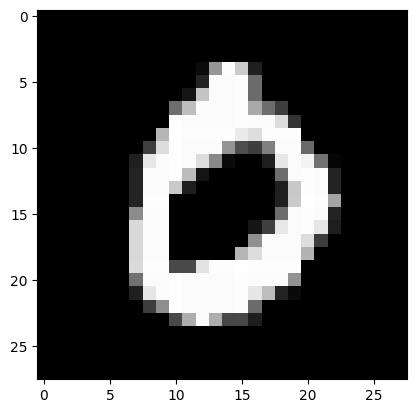

In [51]:
import matplotlib.pyplot as plt

model.eval()

data, target = test_data[3]

data = data.unsqueeze(0).to(device)

output = model(data)

prediction = output.argmax(dim=1, keepdim=True).item()

print(f'Prediction: {prediction}')

image = data.squeeze(0).squeeze(0).cpu().numpy()

plt.imshow(image, cmap='gray')
plt.show()